# signal analysis notebook
このノートブックでは、実際に筆者が書いた関数を呼び出し、それに基づいて信号の可視化を解析・解説しています。ソースコードは同じレポジトリ（src/utils.py）などを参照してください。


必要なパッケージのインストール

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

## メタデータ表示
信号波形は、デジタルな情報の羅列に過ぎません。そこで、それらを物理的に意味のある値として解釈するには、計測点と計測点の幅、使用したセンサの数（チャンネル数）と言ったファイル形式が重要です。これらをすべて出力することがまず必要になります。  
特に、エアリフトの実験においては2023年と2024年でデータ形式・ファイルの命名記法が大きくことなるので、それに応じた処理を行うことが重要です。

In [11]:
from src import analyze_mat_file
if __name__ == "__main__":
    file_path = "D:\csvfiles\sandbox\P20241008-1057.mat"  # Update with your file path
    analyze_mat_file(file_path)

Analyzing: D:\csvfiles\sandbox\P20241008-1057.mat
File size: 3973.64 MB
Successfully loaded .mat file

=== File Metadata ===
__header__: b'PicoScope 7 T&M, Created on: 2025?5?16?'
__version__: 1.0
__globals__: []

=== Variables ===

Variable 1: Tstart
  Type: <class 'numpy.ndarray'>
  Shape: (1, 1)
  Data type: float32
  Min: 0.0
  Max: 0.0
  Mean: 0.0

Variable 2: Tinterval
  Type: <class 'numpy.ndarray'>
  Shape: (1, 1)
  Data type: float64
  Min: 1.9199999812258284e-08
  Max: 1.9199999812258284e-08
  Mean: 1.9199999812258284e-08

Variable 3: ExtraSamples
  Type: <class 'numpy.ndarray'>
  Shape: (1, 1)
  Data type: int32
  Min: 0
  Max: 0
  Mean: 0.0

Variable 4: RequestedLength
  Type: <class 'numpy.ndarray'>
  Shape: (1, 1)
  Data type: int32
  Min: 260416669
  Max: 260416669
  Mean: 260416669.0

Variable 5: Length
  Type: <class 'numpy.ndarray'>
  Shape: (1, 1)
  Data type: int32
  Min: 260416669
  Max: 260416669
  Mean: 260416669.0

Variable 6: Version
  Type: <class 'numpy.ndarr

Loading data...
loading success
cuda
Found 60 triggered pulses
Hilbert transform matrix shape: (60, 5208) (number of pulses x number of samples)
パルス数: 60
画像を保存しました: C:\Users\apetr\Documents\psdata2matlab\tmp\P20240827-1552_tdx1.png
信号波形データを保存しました: C:\Users\apetr\Documents\psdata2matlab\tmp\P20240827-1552_tdx1.npy


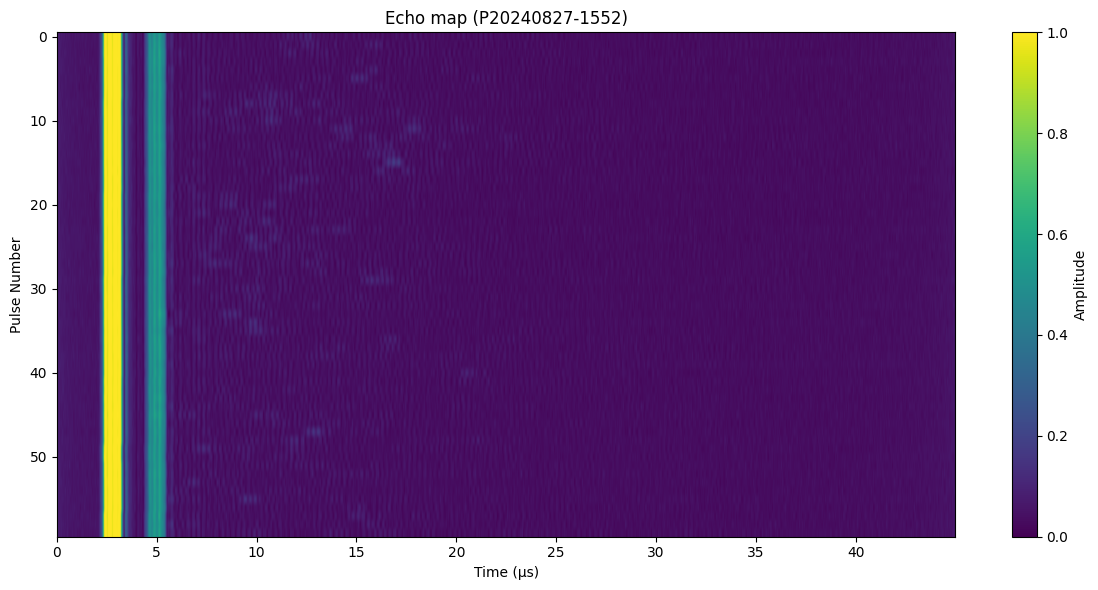

<Figure size 1500x1200 with 0 Axes>

In [3]:
from src import generate_echomap

file_path = "Z:\database\signal_mat\P20240827-1552.mat"
save_dir = "C:\\Users\\apetr\\Documents\\psdata2matlab\\tmp"
triggered_pulses, adjusted_time_us, mean_pulse, std_pulse = generate_echomap(
    file_path, 
    start_time=2, 
    duration=0.02,
    window_width=100e-6, 
    amplitude_threshold=2.0, 
    output_dir=save_dir)

In [8]:
from src import generate_bin_multi

# テスト用のパラメータを設定
file_path = "Z:\database\samples\P20240730-1100.mat"
channels = ["TDX1", "TDX2", "TDX3", "TDX1_enlarged"]  # 処理するチャンネル
start_time = 0.2  # 開始時間（秒）
duration = 0.02  # 分析時間幅（秒）
window_width = 100e-6  # ウィンドウ幅（秒）
amplitude_threshold = 2.0  # 振幅閾値
output_dir = "D:\csvfiles\sandbox"  # 出力ディレクトリ

# 関数を呼び出し
results = generate_bin_multi(
    file_path=file_path,
    channels=channels,
    start_time=start_time,
    duration=duration,
    window_width=window_width,
    amplitude_threshold=amplitude_threshold,
    output_dir=output_dir
)

# 結果の確認
for channel in channels:
    if channel in results:
        print(f"\nChannel {channel} results:")
        print(f"Number of pulses: {results[channel]['n_pulses']}")

Loading data...
Loading successful
Using device: cuda
Detecting triggers from channel TDX1...
Trigger times shape: (60,)
First few trigger times: [0.20000376 0.20033709 0.20067044 0.20100378 0.20133711]
Processing channel TDX1...
Processing channel TDX2...
Processing channel TDX3...
Processing channel TDX1_enlarged...
Saved multi-channel tensor: D:\csvfiles\sandbox\P20240730-1100_multi_channel.npy
Tensor shape: (4, 60, 5208)

Channel TDX1 results:
Number of pulses: 60

Channel TDX2 results:
Number of pulses: 60

Channel TDX3 results:
Number of pulses: 60

Channel TDX1_enlarged results:
Number of pulses: 60


Loading data...
loading success
cuda
Found 3000 triggered pulses
Hilbert transform matrix shape: (3000, 5208) (number of pulses x number of samples)


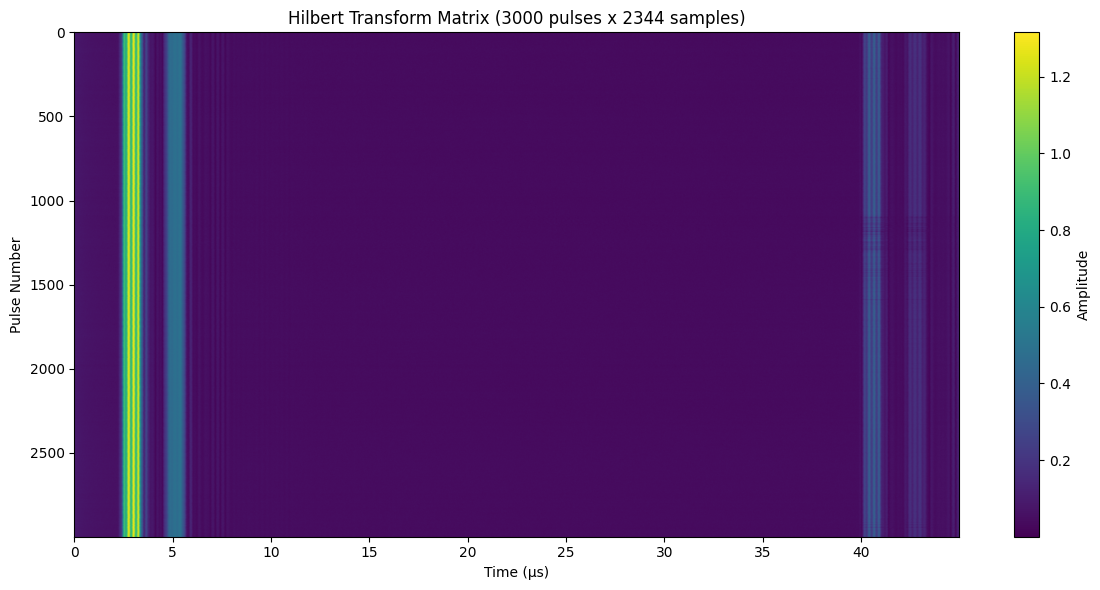

<Figure size 1500x1200 with 0 Axes>

In [41]:
import numpy as np
import scipy.io as sio
import torch
import matplotlib.pyplot as plt
from scipy import signal

def extract_amplitude_triggered_pulses(file_path, start_time=0.444, duration=0.001, 
                                    window_width=50e-6, amplitude_threshold=2.0):
    """
    Function to extract waveforms for a fixed time after amplitude reaches threshold
    Accelerate processing using GPU
    
    Parameters:
    -----------
    file_path : str
        Path to .mat file
    start_time : float
        Start time (seconds)
    duration : float
        Analysis time width (seconds)
    window_width : float
        Width of extraction window (seconds), default 50μs
    amplitude_threshold : float
        Amplitude threshold for triggering
    
    Returns:
    --------
    triggered_pulses : list
        List of triggered pulses
    adjusted_time_us : ndarray
        Adjusted time axis (μs)
    mean_pulse : ndarray
        Mean pulse waveform
    std_pulse : ndarray
        Standard deviation of pulse waveforms
    """
    # Load data
    print("Loading data...")
    mat_data = sio.loadmat(file_path)
    print("loading success")
    signal_data = np.squeeze(mat_data["TDX1"])
    Tinterval = float(mat_data['Tinterval'].item())
    Fs = 1.0 / Tinterval
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    # Extract data from specified time range
    start_idx = int(start_time * Fs)
    duration_samples = int(duration * Fs)
    chunk = signal_data[start_idx:start_idx + duration_samples]
    
    # Transfer to GPU
    chunk_tensor = torch.tensor(chunk, device=device, dtype=torch.float32)
    
    # Detect positions where amplitude exceeds threshold (GPU version)
    window_samples = int(window_width * Fs)
    
    # Detect positions exceeding threshold (parallel processing on GPU)
    threshold_mask = torch.abs(chunk_tensor) >= amplitude_threshold
    potential_triggers = torch.where(threshold_mask)[0].cpu().numpy()
    
    # Select trigger points (avoid duplicates)
    trigger_points = []
    last_trigger = -window_samples
    
    for trigger in potential_triggers:
        if trigger > last_trigger + window_samples:
            trigger_points.append(trigger)
            last_trigger = trigger
    
    # Extract waveforms from each trigger point
    # Initialize lists to store triggered pulses
    triggered_pulses = []  # Store raw pulse data
    
    # Prepare batch for GPU processing
    valid_triggers = [t for t in trigger_points if t + window_samples <= len(chunk)]
    n_pulses = len(valid_triggers)
    
    if n_pulses == 0:
        print("No valid pulses found")
        return [], np.array([]), np.array([]), np.array([])
    
    # Create tensor to store all pulses at once in GPU memory
    all_pulses_tensor = torch.zeros((n_pulses, window_samples), device=device)
    
    # Extract pulse from each trigger point
    for i, trigger in enumerate(valid_triggers):
        all_pulses_tensor[i] = chunk_tensor[trigger:trigger + window_samples]
        # Keep CPU list as well
        triggered_pulses.append(chunk[trigger:trigger + window_samples])
    
    # Remove initial reflection (set 0-55μs signal to 0)
    neglegible_time = 55e-6  # meaningless time
    zero_samples = int(neglegible_time * Fs)  # Calculate samples for 55μs
    
    processed_pulses_tensor = all_pulses_tensor.clone()
    processed_pulses_tensor[:, :zero_samples] = 0  # Set initial part to 0
    
    # Execute Hilbert transform on GPU (Since PyTorch doesn't have direct Hilbert transform,
    # transfer back to CPU and process with SciPy)
    processed_pulses_np = processed_pulses_tensor.cpu().numpy()
    
    # Apply Hilbert transform with batch processing
    from scipy.signal import hilbert
    hilbert_matrix = np.zeros_like(processed_pulses_np)
    
    for i in range(n_pulses):
        analytic_signal = hilbert(processed_pulses_np[i])
        hilbert_matrix[i] = np.abs(analytic_signal)
    
    # Transfer results back to GPU if needed
    hilbert_tensor = torch.tensor(hilbert_matrix, device=device)
    
    print(f"Found {n_pulses} triggered pulses")
    
    # Generate time axis (in μs)
    pulse_time_us = np.arange(window_samples) * Tinterval * 1e6
    
    # Time axis adjusted for zero point
    adjusted_time_us = np.arange(-zero_samples, window_samples-zero_samples) * Tinterval * 1e6
    
    print(f"Hilbert transform matrix shape: {hilbert_matrix.shape} (number of pulses x number of samples)")
    
    # Create Hilbert transform matrix excluding time from -60 to 0
    hilbert_matrix_trimmed = hilbert_matrix[:, zero_samples:]
    adjusted_time_us_trimmed = adjusted_time_us[adjusted_time_us >= 0]
    
    # Plot the entire matrix
    plt.figure(figsize=(12, 6))
    plt.imshow(hilbert_matrix_trimmed, aspect='auto', cmap='viridis', 
               extent=[0, adjusted_time_us_trimmed[-1], n_pulses-0.5, -0.5])
    plt.colorbar(label='Amplitude')
    plt.xlabel('Time (μs)')
    plt.ylabel('Pulse Number')
    plt.title(f'Hilbert Transform Matrix ({n_pulses} pulses x {hilbert_matrix_trimmed.shape[1]} samples)')
    plt.tight_layout()
    plt.show()
    # Calculate average waveform (executed on GPU)
    mean_pulse = torch.mean(all_pulses_tensor, dim=0).cpu().numpy()
    std_pulse = torch.std(all_pulses_tensor, dim=0).cpu().numpy()
    
    # Average waveform of Hilbert transform
    mean_hilbert = torch.mean(hilbert_tensor, dim=0).cpu().numpy()
    std_hilbert = torch.std(hilbert_tensor, dim=0).cpu().numpy()
    
    plt.figure(figsize=(15, 12))
    
    return triggered_pulses, adjusted_time_us, mean_pulse, std_pulse

# Usage example
file_path = "Z:\database\samples\P20240726-1600.mat"
#plot_signal_waveform(file_path, start_ms=100, end_ms=101)
pulses, time, mean_pulse, std_pulse = extract_amplitude_triggered_pulses(
    file_path,
    start_time=2.0, #seconds, measurement start point
    duration=1, #seconds, measurement time
    window_width=100e-6, #pulse occurs 3 times per 1ms as we're irradiating at 3kHz
    amplitude_threshold=2.0
)

In [ ]:
from src import generate_bin_multi
file_path = "D:\csvfiles\sandbox\P20240726-1600.mat"
generate_bin_multi(file_path, channels=["TDX1", "TDX2","TDX3","TDX1_enlarged"], start_time=0.0, duration=5, starting_window=55e-6, ending_window=105e-6, amplitude_threshold=2.0, output_dir="D:\csvfiles\sandbox")

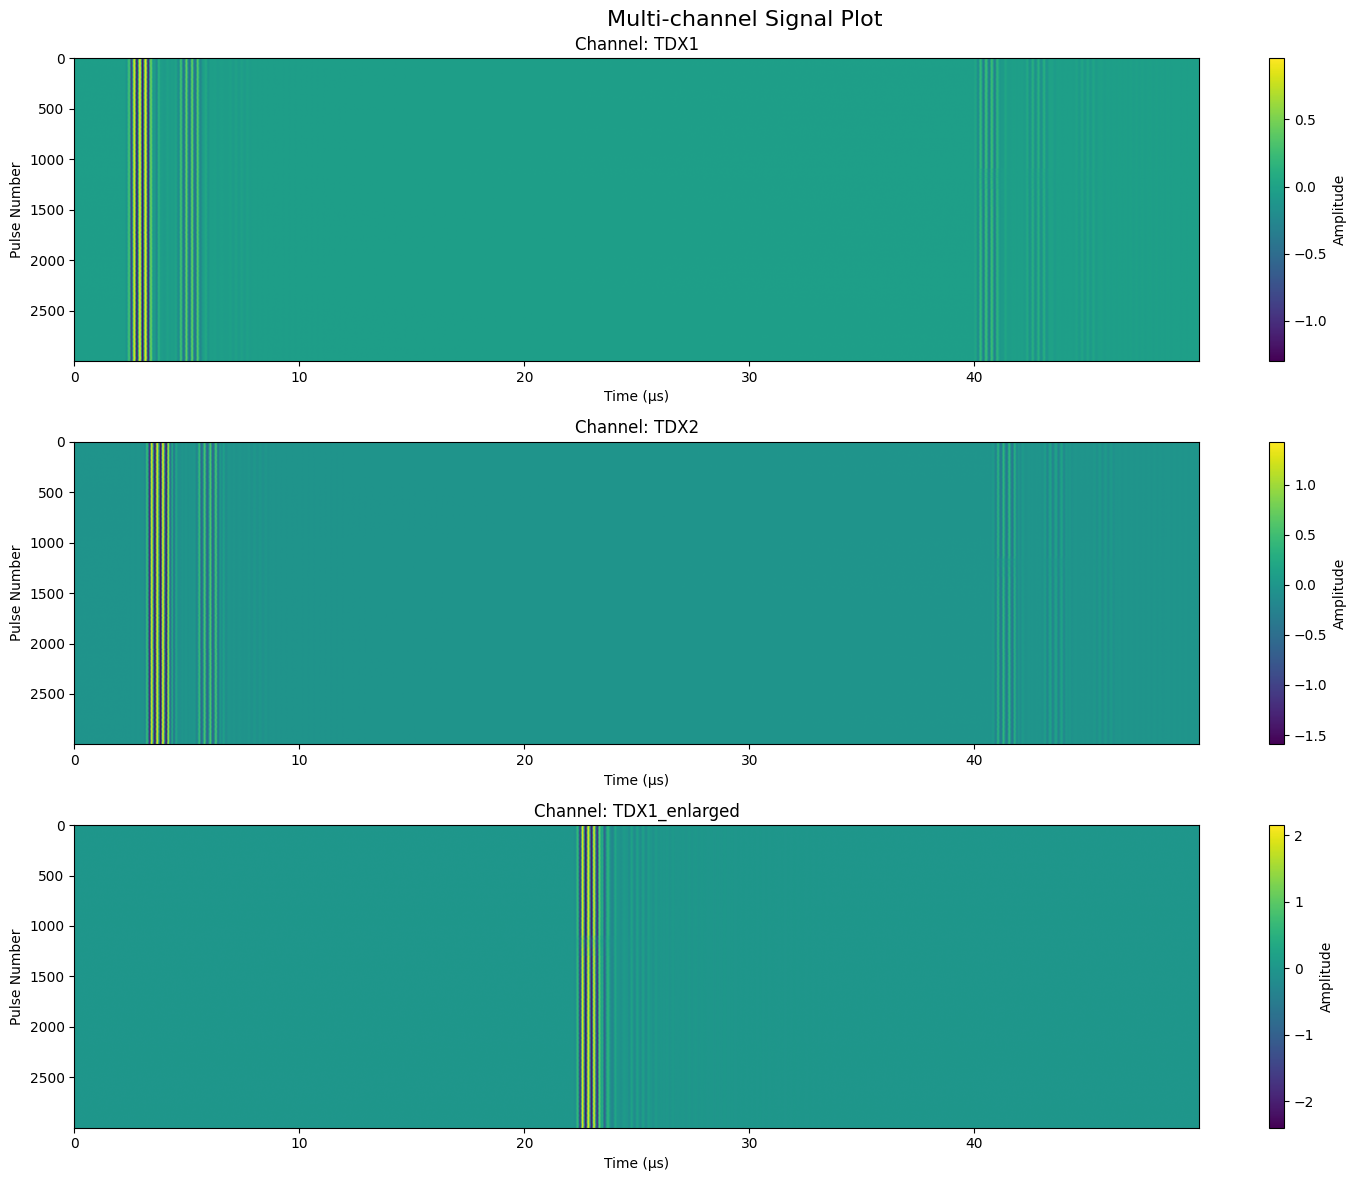

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Load data
data = np.load('D:\csvfiles\sandbox\P20240726-1600_multi_channel.npz', allow_pickle=True)
signal_data = data['signal_data']

# メタデータの読み込み
metadata = data['metadata'].item()
Tinterval = metadata['Tinterval']  # サンプリング間隔を取得

# List of channel names
channels = ['TDX1', 'TDX2', 'TDX1_enlarged']

# Plot settings
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Multi-channel Signal Plot', fontsize=16)

# Plot for each channel
for i, channel in enumerate(channels):
    # Get channel index
    channel_idx = channels.index(channel)
    
    # Get and preprocess data
    channel_data = signal_data[channel_idx]
    
    # Replace infinite values with NaN
    channel_data = np.where(np.isinf(channel_data), np.nan, channel_data)
    
    # Calculate time axis using Tinterval from metadata (convert to microseconds)
    time_axis = np.arange(channel_data.shape[1]) * Tinterval * 1e6  # Convert seconds to microseconds
    
    # Plot
    im = axes[i].imshow(channel_data, aspect='auto', cmap='viridis',
                       extent=[0, time_axis[-1], channel_data.shape[0]-0.5, -0.5])
    axes[i].set_title(f'Channel: {channel}')
    axes[i].set_xlabel('Time (μs)')  # Time axis is now in microseconds
    axes[i].set_ylabel('Pulse Number')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[i], label='Amplitude')

plt.tight_layout()
plt.show()